In [ ]:
%%capture
! pip install datasets transformers
! pip install accelerate

In [ ]:
from datasets import load_dataset

ds = load_dataset("keremberke/chest-xray-classification", name="full")
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4077 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1165 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/582 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4077
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1165
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 582
    })
})

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-7-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments
import accelerate

training_args = TrainingArguments(
  output_dir="./vit-base-chest-xray-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1176949000GF
  train_loss               =       0.0846
  train_runtime            =   0:10:29.38
  train_samples_per_second =       25.911
  train_steps_per_second   =        1.621


In [ ]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9794
  eval_loss               =     0.0737
  eval_runtime            = 0:00:15.13
  eval_samples_per_second =     76.955
  eval_steps_per_second   =      9.644


In [ ]:
import numpy as np
from PIL import Image
import random

normal_pairs = [(img, label) for img, label in zip(ds['test']['image'], ds['test']['labels']) if label == 0]

pneumonia_pairs = [(img, label) for img, label in zip(ds['test']['image'], ds['test']['labels']) if label == 1]

selected_normal_pairs = random.sample(normal_pairs, 5)
selected_pneumonia_pairs = random.sample(pneumonia_pairs, 5)

selected_pairs = selected_normal_pairs + selected_pneumonia_pairs

samples = [{
    'pixel_values': feature_extractor(images=Image.fromarray(np.uint8(np.array(img) * 255)), return_tensors="pt")['pixel_values'],
    'label': label
} for img, label in selected_pairs]

Predicted: Pneumonia, Actual: Normal


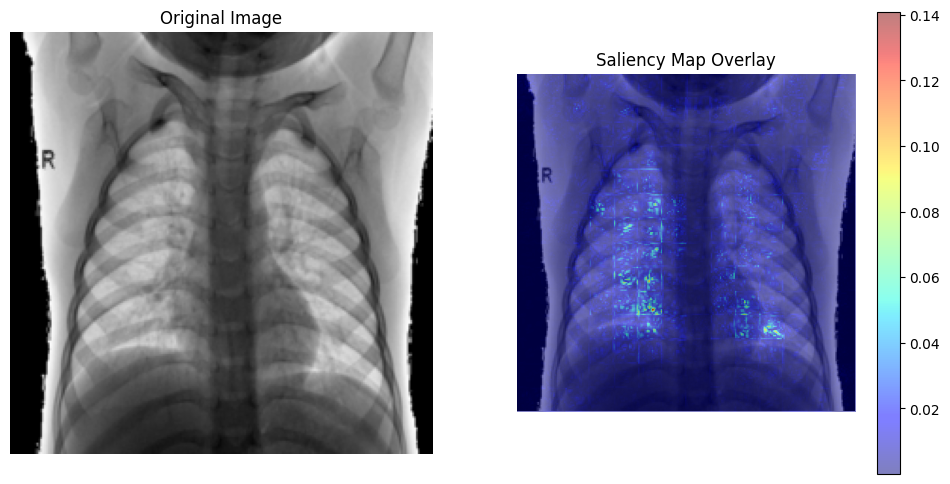

Predicted: Normal, Actual: Normal


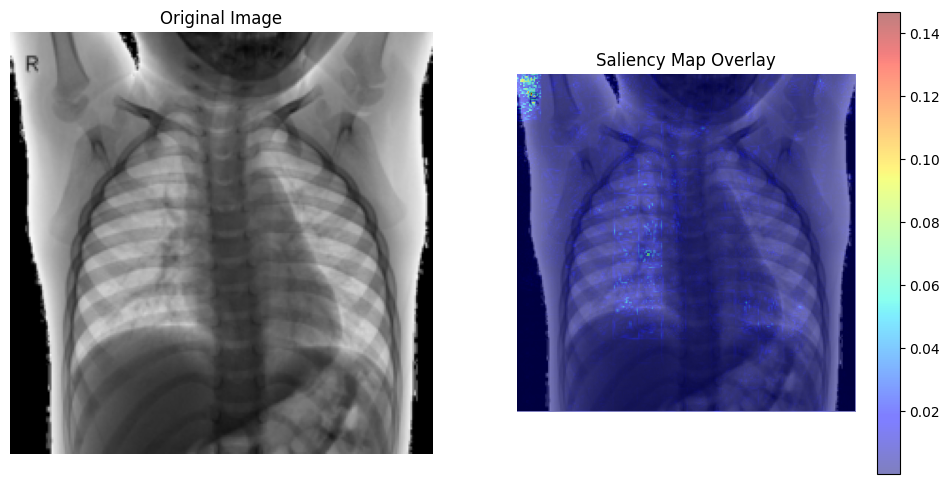

Predicted: Pneumonia, Actual: Normal


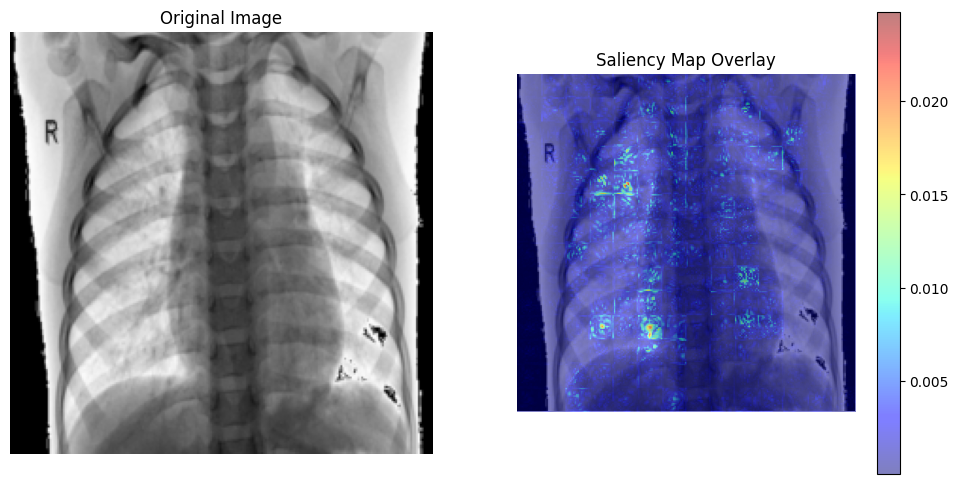

Predicted: Pneumonia, Actual: Normal


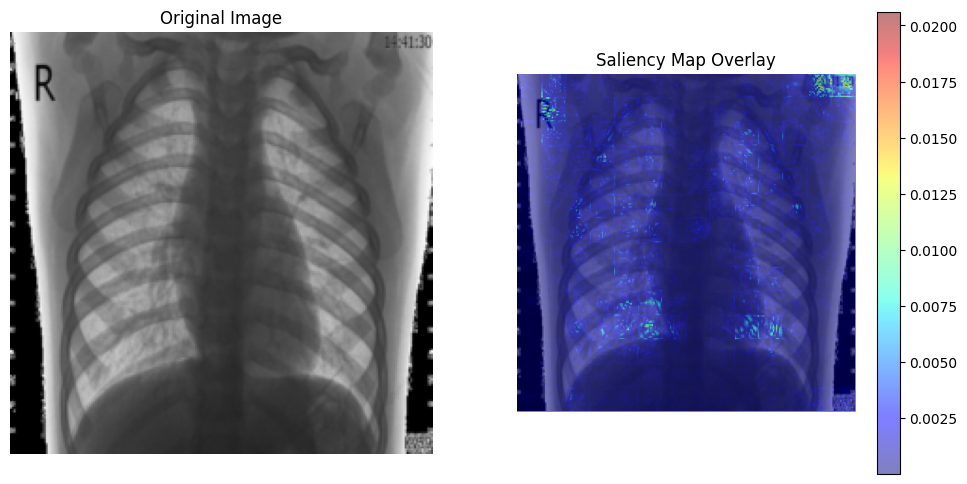

Predicted: Normal, Actual: Normal


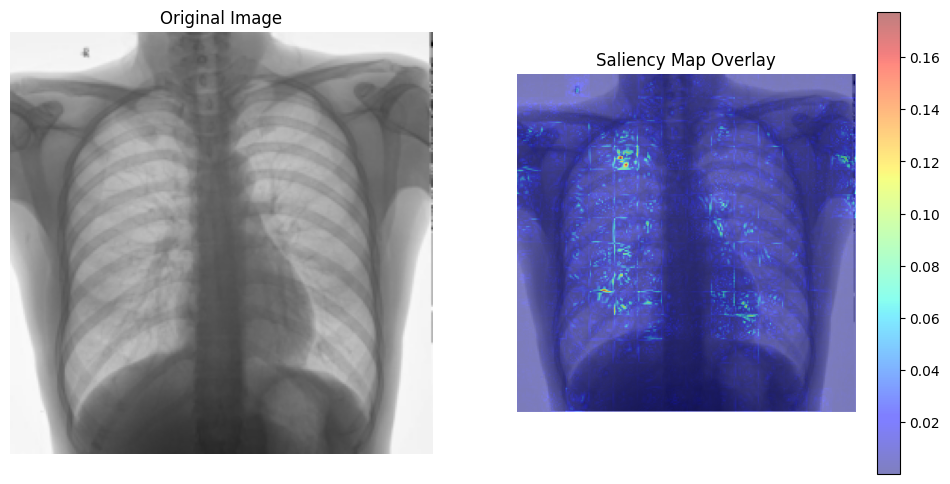

Predicted: Pneumonia, Actual: Pneumonia


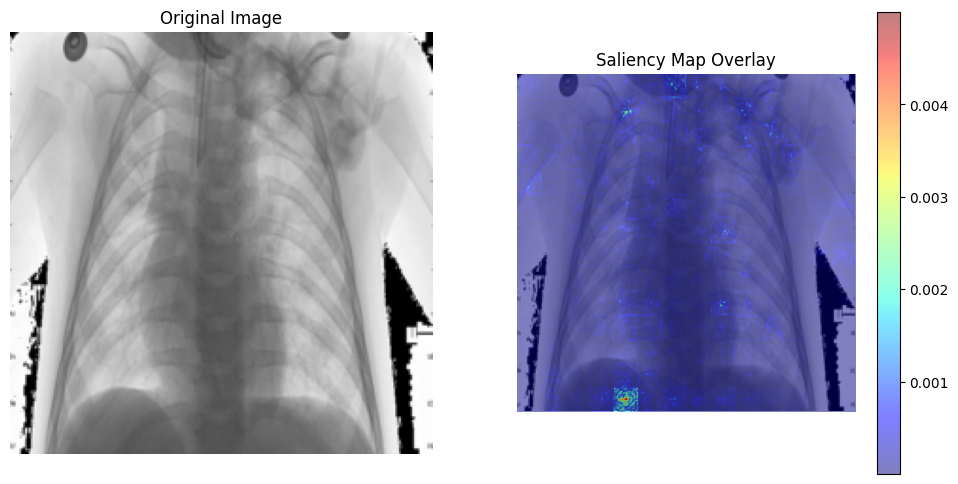

Predicted: Pneumonia, Actual: Pneumonia


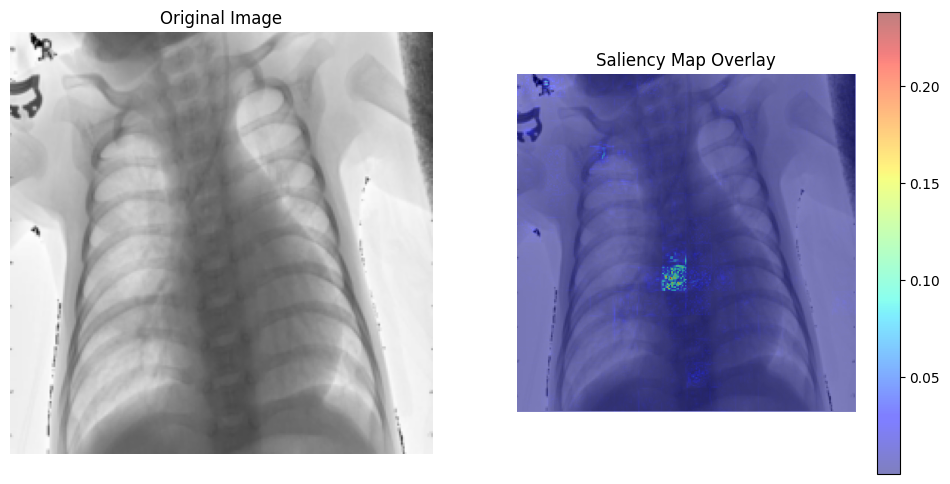

Predicted: Normal, Actual: Pneumonia


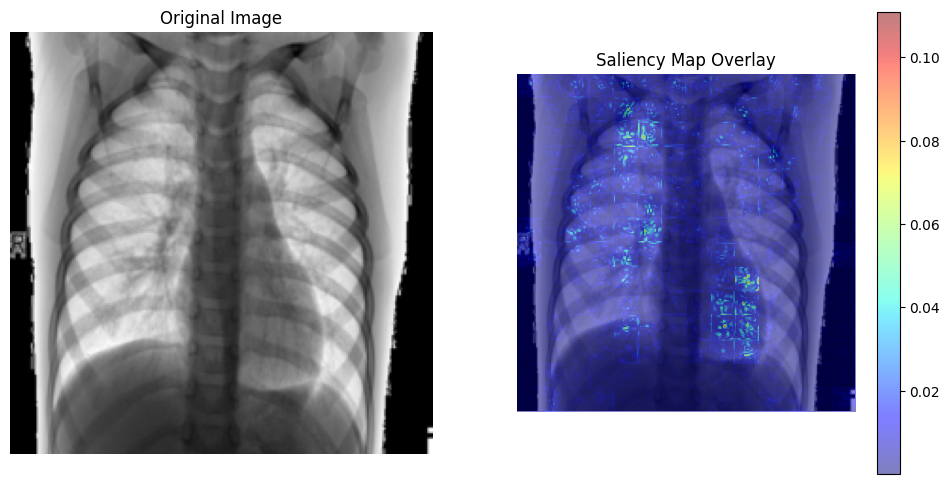

Predicted: Pneumonia, Actual: Pneumonia


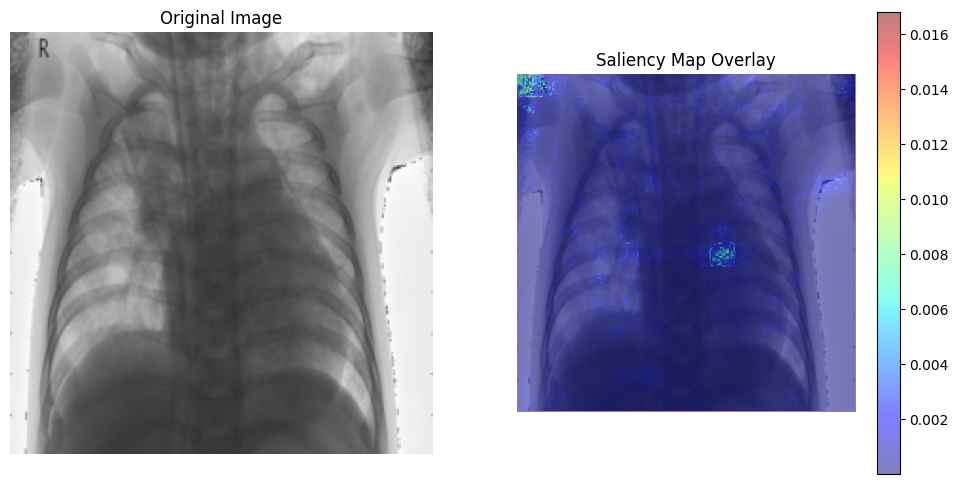

Predicted: Pneumonia, Actual: Pneumonia


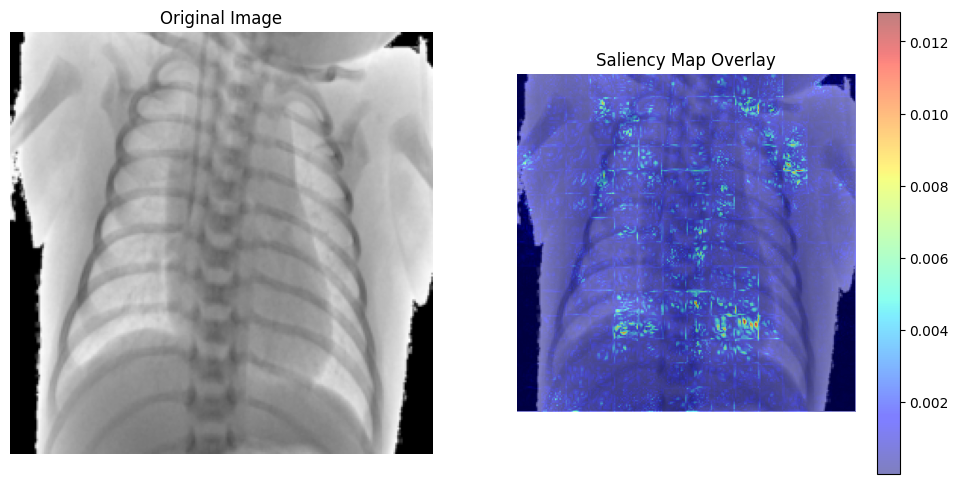

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_and_plot_saliency_overlay_label(model, input_tensor, label):
    model.eval()

    input_tensor = input_tensor.detach()
    input_tensor.requires_grad_(True)

    outputs = model(input_tensor)
    logits = outputs.logits

    predicted_class = logits.argmax(dim=-1)

    if label == 0:
        label = 'Normal'
    else:
        label = 'Pneumonia'

    prediction = 0

    if predicted_class.item() == 0:
        prediction = 'Normal'
    else:
        prediction = 'Pneumonia'

    print(f'Predicted: {prediction}, Actual: {label}')

    score = logits[torch.arange(logits.size(0)), predicted_class]
    score = score.sum()

    score.backward()

    saliency = input_tensor.grad.data.abs().squeeze().mean(dim=0).cpu()

    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input_img = input_tensor.detach().squeeze().cpu().numpy().transpose(1, 2, 0)
    input_img = std * input_img + mean
    input_img = np.clip(input_img, 0, 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(input_img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(input_img)

    plt.imshow(saliency, cmap='jet', alpha=0.5, extent=[0, input_img.shape[1], input_img.shape[0], 0])
    plt.colorbar()
    plt.title('Saliency Map Overlay')
    plt.axis('off')
    plt.show()

#Visualizing Attention for Test Set
for i in range(10):
    sample = samples[i]
    input_tensor = sample['pixel_values']
    label = sample['label']
    input_tensor = input_tensor.to(model.device)
    generate_and_plot_saliency_overlay_label(model, input_tensor, label)

Predicted: Normal, Actual: Normal


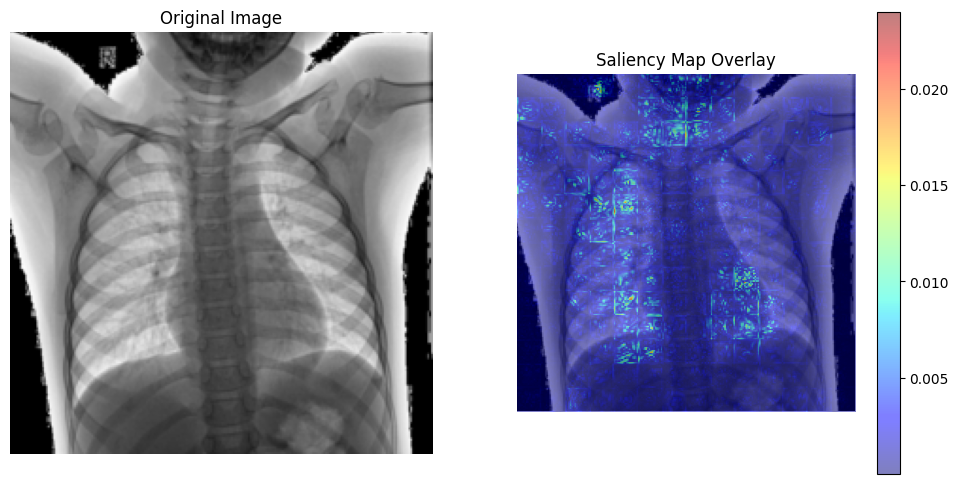

Predicted: Pneumonia, Actual: Normal


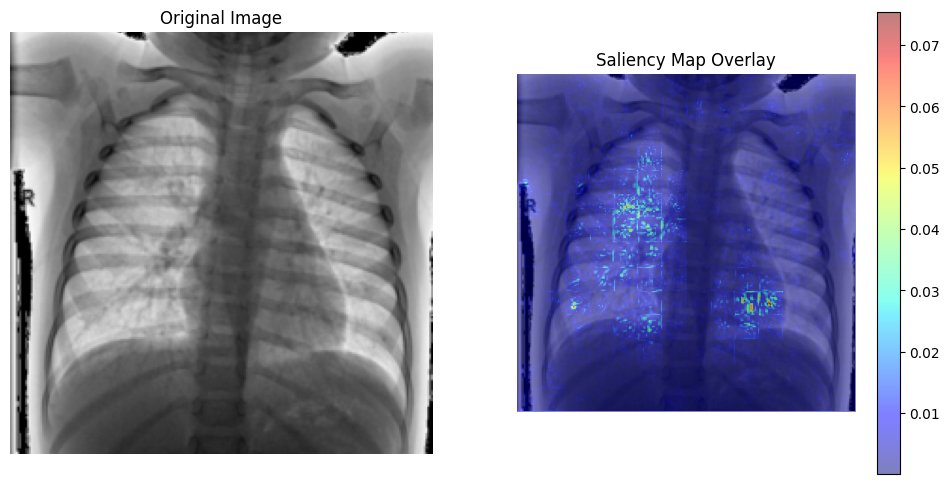

Predicted: Normal, Actual: Normal


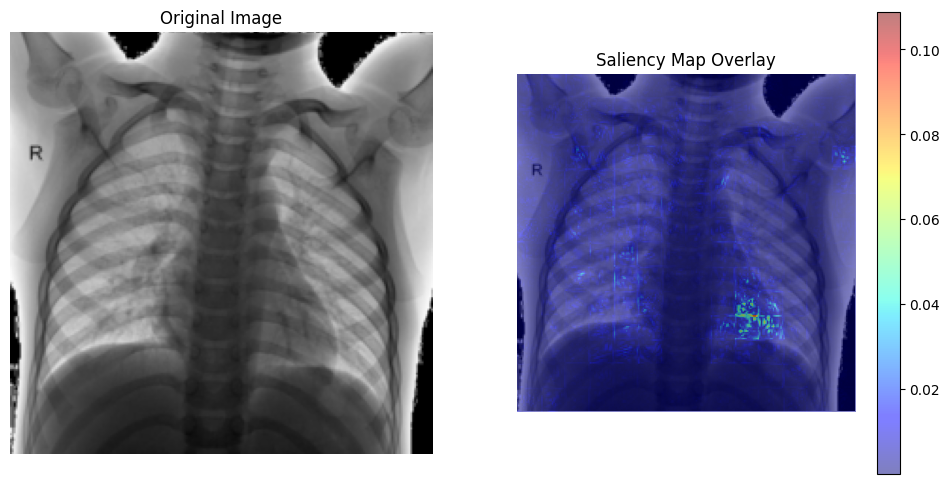

Predicted: Pneumonia, Actual: Normal


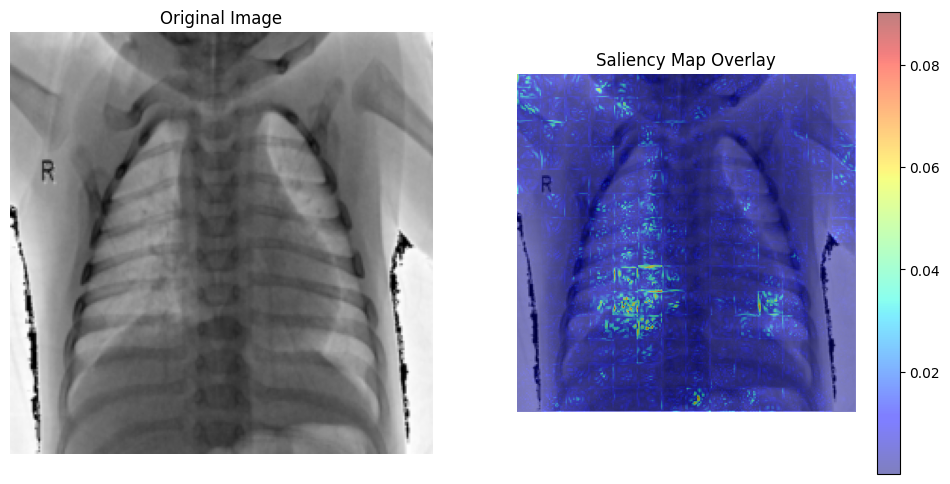

Predicted: Normal, Actual: Normal


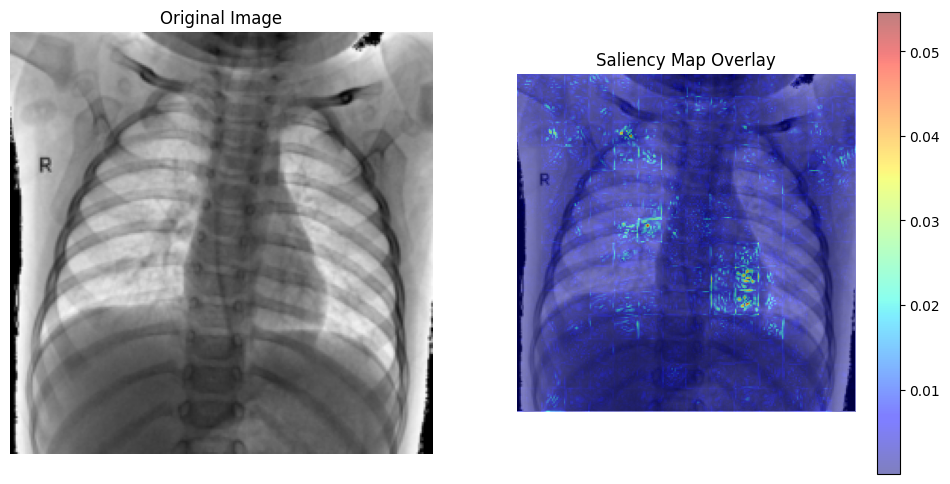

Predicted: Pneumonia, Actual: Pneumonia


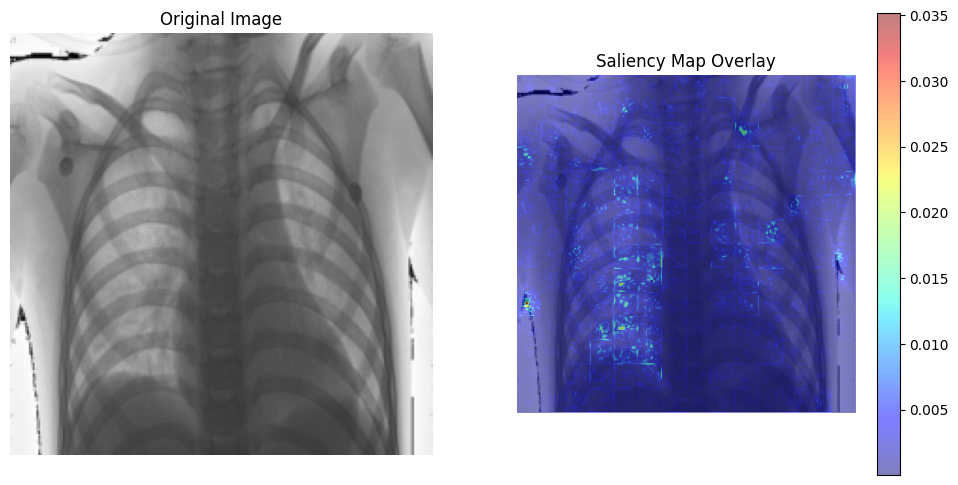

Predicted: Pneumonia, Actual: Pneumonia


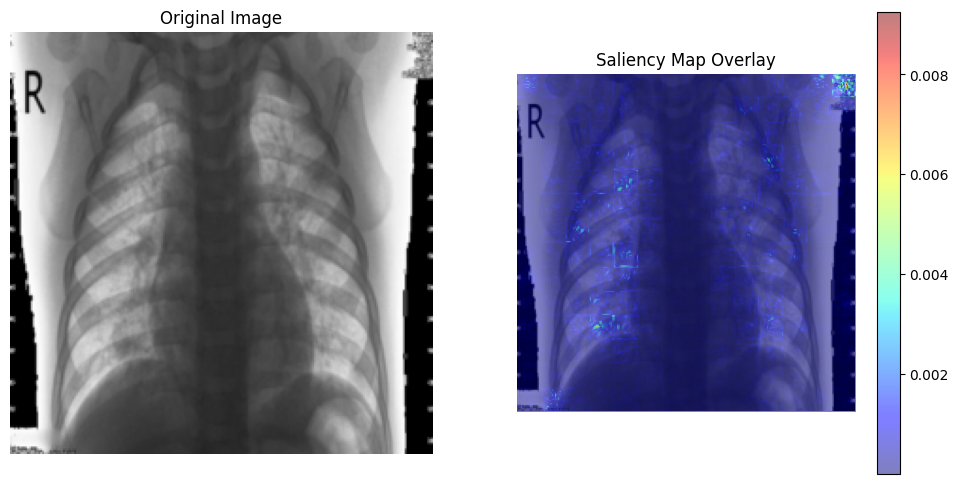

Predicted: Pneumonia, Actual: Pneumonia


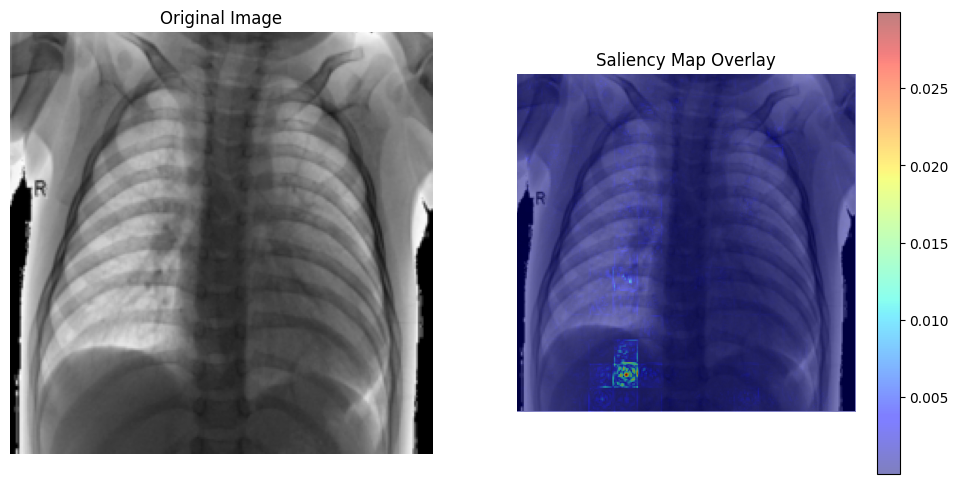

Predicted: Pneumonia, Actual: Pneumonia


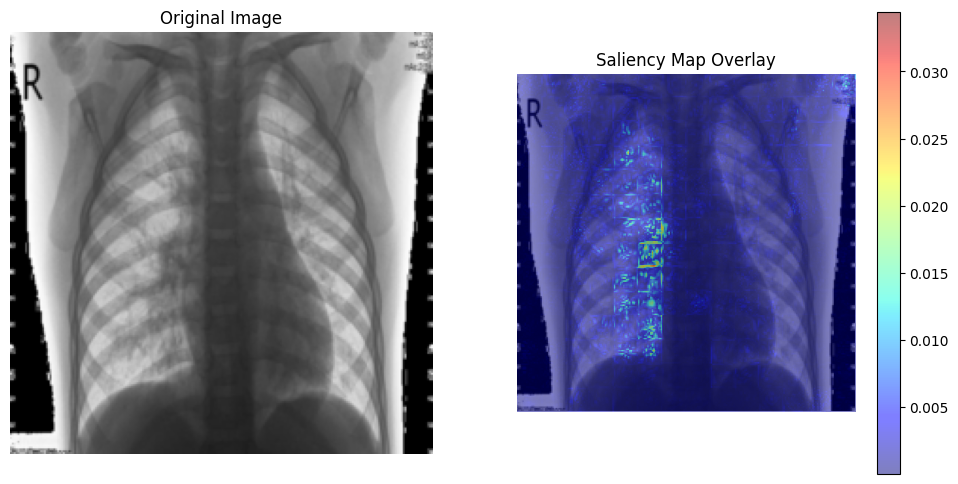

Predicted: Pneumonia, Actual: Pneumonia


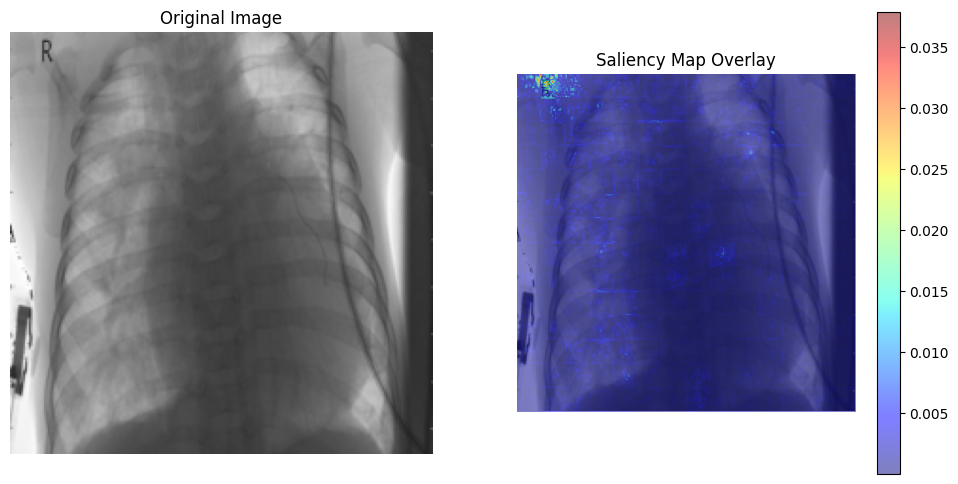

In [ ]:
import numpy as np
from PIL import Image
import random

normal_pairs = [(img, label) for img, label in zip(ds['train']['image'], ds['train']['labels']) if label == 0]

pneumonia_pairs = [(img, label) for img, label in zip(ds['train']['image'], ds['train']['labels']) if label == 1]

selected_normal_pairs = random.sample(normal_pairs, 5)
selected_pneumonia_pairs = random.sample(pneumonia_pairs, 5)

selected_pairs = selected_normal_pairs + selected_pneumonia_pairs

samples = [{
    'pixel_values': feature_extractor(images=Image.fromarray(np.uint8(np.array(img) * 255)), return_tensors="pt")['pixel_values'],
    'label': label
} for img, label in selected_pairs]

#Visualizing Attention for Train Set
for i in range(10):
    sample = samples[i]
    input_tensor = sample['pixel_values']
    label = sample['label']
    input_tensor = input_tensor.to(model.device)
    generate_and_plot_saliency_overlay_label(model, input_tensor, label)